In [38]:
import sys

sys.path.append("../")
import pandas as pd
from config.settings import MONGO_CONNECTION_STRING
from datetime import datetime, timedelta
from src.indicators.sma import calculate_sma
from pymongo import MongoClient
import json

In [11]:
client = MongoClient(
    MONGO_CONNECTION_STRING,
    tls=True,
    tlsAllowInvalidCertificates=True,  # For development only
    # tlsCAFile='/Users/tyrelle/Desktop/4ex.ninja/4ex.ninja/config/global-bundle.pem'
)

In [20]:
db = client["forex_data"]
collections = db.list_collection_names()


In [23]:
collections

['EUR_USD_H1',
 'EUR_USD_H4',
 'GBP_USD_H4',
 'EUR_GBP_D',
 'USD_JPY_H1',
 'AUD_USD_H4',
 'GBP_USD_D',
 'USD_CAD_H1',
 'USD_CAD_D',
 'USD_CAD_H4',
 'NZD_USD_H1',
 'EUR_GBP_H1',
 'AUD_USD_D',
 'EUR_USD_D',
 'NZD_USD_D',
 'GBP_JPY_D',
 'GBP_USD_H1',
 'NZD_USD_H4',
 'EUR_GBP_H4',
 'EUR_USD_M15',
 'USD_JPY_D',
 'GBP_JPY_H1',
 'GBP_JPY_H4',
 'USD_JPY_H4',
 'AUD_USD_H1']

In [29]:
# Choose a collection (for example EUR_USD_H4)
collection_name = "EUR_USD_H4"
collection = db[collection_name]

# Fetch all documents and convert to DataFrame
df_EURUSD_H4 = pd.DataFrame(list(collection.find()))

# Set the time column as the index
df_EURUSD_H4.set_index("time", inplace=True)

# Extract OHLC values from the mid dictionary
df_EURUSD_H4["open"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["o"]))
df_EURUSD_H4["high"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["h"]))
df_EURUSD_H4["low"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["l"]))
df_EURUSD_H4["close"] = df_EURUSD_H4["mid"].apply(lambda x: float(x["c"]))

# Drop unnecessary columns and reorder
df_EURUSD_H4 = df_EURUSD_H4[["volume", "open", "high", "low", "close"]]

# Display information about the data
print(f"\nDataFrame info for {collection_name}:")
print(f"Total number of candles: {len(df_EURUSD_H4)}")
print("\nFirst few rows:")
print(df_EURUSD_H4.head())


DataFrame info for EUR_USD_H4:
Total number of candles: 15547

First few rows:
                     volume     open     high      low    close
time                                                           
2015-02-15 22:00:00    3193  1.13999  1.14120  1.13893  1.14086
2015-02-16 02:00:00    1412  1.14082  1.14226  1.14030  1.14144
2015-02-16 06:00:00    3400  1.14144  1.14291  1.13955  1.14034
2015-02-16 10:00:00    2865  1.14030  1.14203  1.13969  1.14064
2015-02-16 14:00:00    4829  1.14066  1.14150  1.13408  1.13564


Matplotlib is building the font cache; this may take a moment.


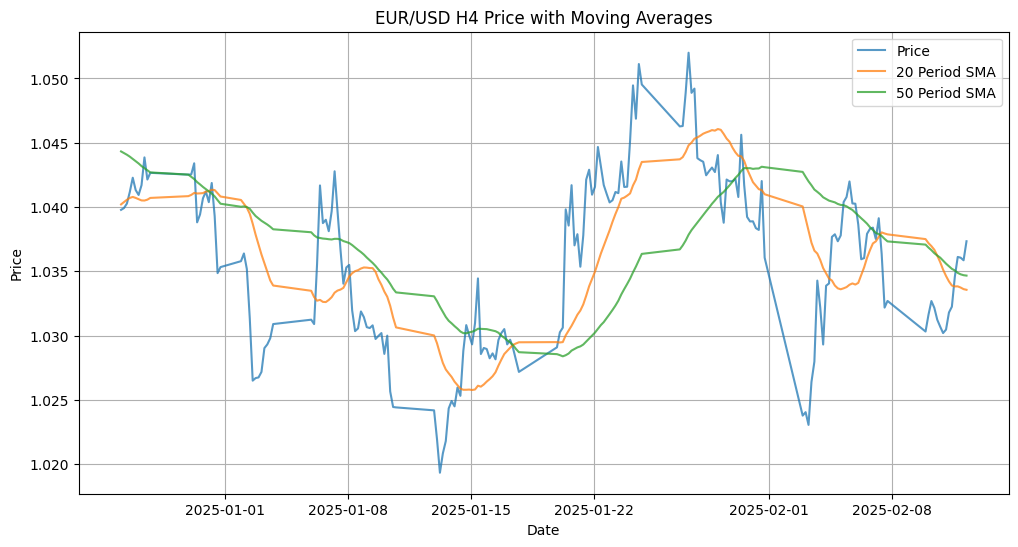

In [41]:
# Calculate moving averages
df_EURUSD_H4["SMA_20"] = calculate_sma(df_EURUSD_H4["close"], [20])[
    "sma_20"
]  # Pass period as a list
df_EURUSD_H4["SMA_50"] = calculate_sma(df_EURUSD_H4["close"], [50])[
    "sma_50"
]  # Pass period as a list

# Import plotting library
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    df_EURUSD_H4.index[-200:], df_EURUSD_H4["close"][-200:], label="Price", alpha=0.75
)
plt.plot(
    df_EURUSD_H4.index[-200:],
    df_EURUSD_H4["SMA_20"][-200:],
    label="20 Period SMA",
    alpha=0.75,
)
plt.plot(
    df_EURUSD_H4.index[-200:],
    df_EURUSD_H4["SMA_50"][-200:],
    label="50 Period SMA",
    alpha=0.75,
)

plt.title("EUR/USD H4 Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()